# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

Learning Standard Hopf Bifurcation with linearly increasing bifurcation parameter 

Model saved as hopf_node_model_v5

In [ ]:
from torchdiffeq import odeint as odeint

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d

from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds

: 

# Data Geneation

Hopf Bifurcation

$\alpha > 0$ for supercritical

$\alpha < 0$ for subcritical

$$ 
\begin{aligned}
\dot r = r (\rho + \alpha r^2) \\
\dot \theta = \omega + \beta r^2
\end{aligned}
$$

fixed points at $r = 0$ and $r = \sqrt{\frac{-\rho}{\alpha}}$


In [ ]:
class Hopf(ds.DynamicalSystem_torch):
    def __init__(self, rho=1.0, alpha=1.0, omega = 1.0, beta=1.0):
        super().__init__()
        self.rho = rho 
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = 0.1 #Rate of change of bifurcation parameter
        self.system_dim = 2


    def f(self, t, x): 
        #x sould be (traj, dim)
        if not isinstance(x, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor, got {type(x)}")
        elif len(x.shape) == 1:
            if x.shape[0] != self.system_dim: 
                raise ValueError("x must have dimension of 2")
            else:
                x = x.unsqueeze(0)
        elif len(x.shape) == 2: 
            if x.shape[1] != self.system_dim: 
                raise ValueError("x.shape[1] must have dimension of ", self.system_dim)
        else:
            raise ValueError("Input tensor x cannot have more than 2 dimensions (trajectory, dimension)")
        
        xdot = self.rho * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)
    
    def na_f(self, t, x):
        xdot = x[:, 2] * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + x[:, 2] * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        rdot = self.gamma*torch.ones_like(x[:, 0]) #Rate of change of bifurcation parameter
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1), rdot.unsqueeze(1)], dim = 1)


: 

In [ ]:
lc = Hopf(rho=1.0, alpha=-1.0, beta=0.0)
#Supercritical hopf 

: 

In [ ]:
y0 = torch.tensor([[1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [0.0, 0.0, 1.0]])
y0.shape

: 

In [ ]:
lc.na_f(t = 0, x = y0).shape

: 

In [ ]:
sol = odeint(func=lc.na_f, y0=y0, t=torch.arange(0, 10, 0.1), method='rk4')

: 

In [ ]:
a = torch.arange(-2.0, 2.0, 0.5); b = torch.arange(-2, 2, 0.5); c = torch.ones_like(a)
ic = torch.cartesian_prod(a, b, torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]))  #traj, dim


t_span = (0, 10); dt = 0.05
ic.shape #traj, dim


: 

In [ ]:
lc.f = lc.na_f

: 

In [ ]:
sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )


: 

In [ ]:
for i in range(ic.shape[0]):
    plt.plot(sol[:, i, 0], sol[:, i, 1])

: 

In [ ]:
training_data_tensor = sol.unsqueeze(0)
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

: 

In [13]:
print(training_data_tensor.shape, t_eval_tensor.shape)

torch.Size([1, 200, 320, 3]) torch.Size([1, 200])


# Neural ODE - 

In [14]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

In [16]:
model = NODE(input_dim=lc.system_dim+1, output_dim=lc.system_dim+1, depth=5, width=20, activation_func=nn.Tanh())  

In [17]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




In [19]:
training_data_tensor.shape, t_eval_tensor.shape

(torch.Size([1, 200, 320, 3]), torch.Size([1, 200]))

In [83]:
num_epochs = 500


for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:01<08:47,  1.06s/it]

Epoch 0, Loss: 0.05524986609816551


  4%|▍         | 21/500 [00:16<06:00,  1.33it/s]

Epoch 20, Loss: 0.055506572127342224


  8%|▊         | 41/500 [00:30<05:28,  1.40it/s]

Epoch 40, Loss: 0.05112788453698158


 12%|█▏        | 61/500 [00:44<05:06,  1.43it/s]

Epoch 60, Loss: 0.04910802096128464


 16%|█▌        | 81/500 [00:57<04:40,  1.49it/s]

Epoch 80, Loss: 0.050124023109674454


 20%|██        | 101/500 [01:11<04:36,  1.44it/s]

Epoch 100, Loss: 0.05100660026073456


 24%|██▍       | 121/500 [01:25<04:31,  1.40it/s]

Epoch 120, Loss: 0.0516853854060173


 28%|██▊       | 141/500 [01:39<04:06,  1.46it/s]

Epoch 140, Loss: 0.047401413321495056


 32%|███▏      | 161/500 [01:53<03:46,  1.50it/s]

Epoch 160, Loss: 0.04709022119641304


 36%|███▌      | 181/500 [02:07<03:35,  1.48it/s]

Epoch 180, Loss: 0.05017487704753876


 40%|████      | 201/500 [02:21<03:30,  1.42it/s]

Epoch 200, Loss: 0.04700736328959465


 44%|████▍     | 221/500 [02:35<03:08,  1.48it/s]

Epoch 220, Loss: 0.04332978278398514


 48%|████▊     | 241/500 [02:49<03:17,  1.31it/s]

Epoch 240, Loss: 0.043357741087675095


 52%|█████▏    | 261/500 [03:04<02:49,  1.41it/s]

Epoch 260, Loss: 0.04746714606881142


 56%|█████▌    | 281/500 [03:21<03:15,  1.12it/s]

Epoch 280, Loss: 0.04265204817056656


 60%|██████    | 301/500 [03:38<03:35,  1.08s/it]

Epoch 300, Loss: 0.04277734458446503


 64%|██████▍   | 321/500 [03:56<02:33,  1.17it/s]

Epoch 320, Loss: 0.04164886102080345


 68%|██████▊   | 341/500 [04:11<01:56,  1.37it/s]

Epoch 340, Loss: 0.040473051369190216


 72%|███████▏  | 361/500 [04:25<01:35,  1.46it/s]

Epoch 360, Loss: 0.03877602145075798


 76%|███████▌  | 381/500 [04:40<01:37,  1.23it/s]

Epoch 380, Loss: 0.03810756281018257


 80%|████████  | 401/500 [04:57<01:26,  1.15it/s]

Epoch 400, Loss: 0.037351079285144806


 84%|████████▍ | 421/500 [05:13<01:08,  1.15it/s]

Epoch 420, Loss: 0.03864719718694687


 88%|████████▊ | 441/500 [05:32<01:20,  1.37s/it]

Epoch 440, Loss: 0.03954817354679108


 92%|█████████▏| 461/500 [06:02<01:07,  1.73s/it]

Epoch 460, Loss: 0.04014938697218895


 96%|█████████▌| 481/500 [06:44<00:45,  2.38s/it]

Epoch 480, Loss: 0.04160002991557121


100%|██████████| 500/500 [07:13<00:00,  1.15it/s]


In [21]:
torch.save(model, 'hopf_node_model_v5.pth')

In [ ]:
model = torch.load('hopf_node_model_v5.pth', weights_only=False)

In [112]:
# Analysis of Trained Model

Text(0.5, 0, 'Epochs')

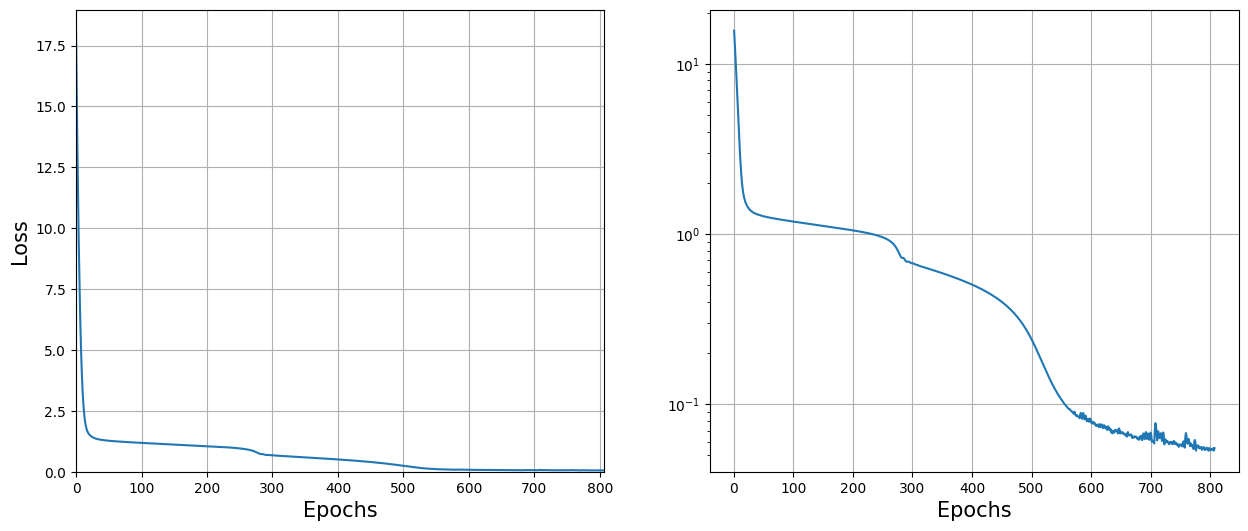

In [22]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

torch.Size([110])

In [ ]:
r_vals = torch.arange(-1.0, 10.0, 0.1)

a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b, r_vals)

t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
node_data = odeint(model, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

In [21]:
true_data.shape

torch.Size([400, 11000, 3])

#Plotting results
fig = plt.figure(figsize=(10, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1)
for i in range(pts.shape[0]):
    ax1.arrow(x=true_data[0, i, 0].detach().numpy(), y=true_data[0, i, 1].detach().numpy(), 
          dx=true_data[10, i, 0].detach().numpy() - true_data[0, i, 0].detach().numpy(), 
          dy=true_data[10, i, 1].detach().numpy() - true_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')


#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2)
for i in range(pts.shape[0]):
    ax2.arrow(x=node_data[0, i, 0].detach().numpy(), y=node_data[0, i, 1].detach().numpy(), 
          dx=node_data[10, i, 0].detach().numpy() - node_data[0, i, 0].detach().numpy(), 
          dy=node_data[10, i, 1].detach().numpy() - node_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')

    



plt.show()

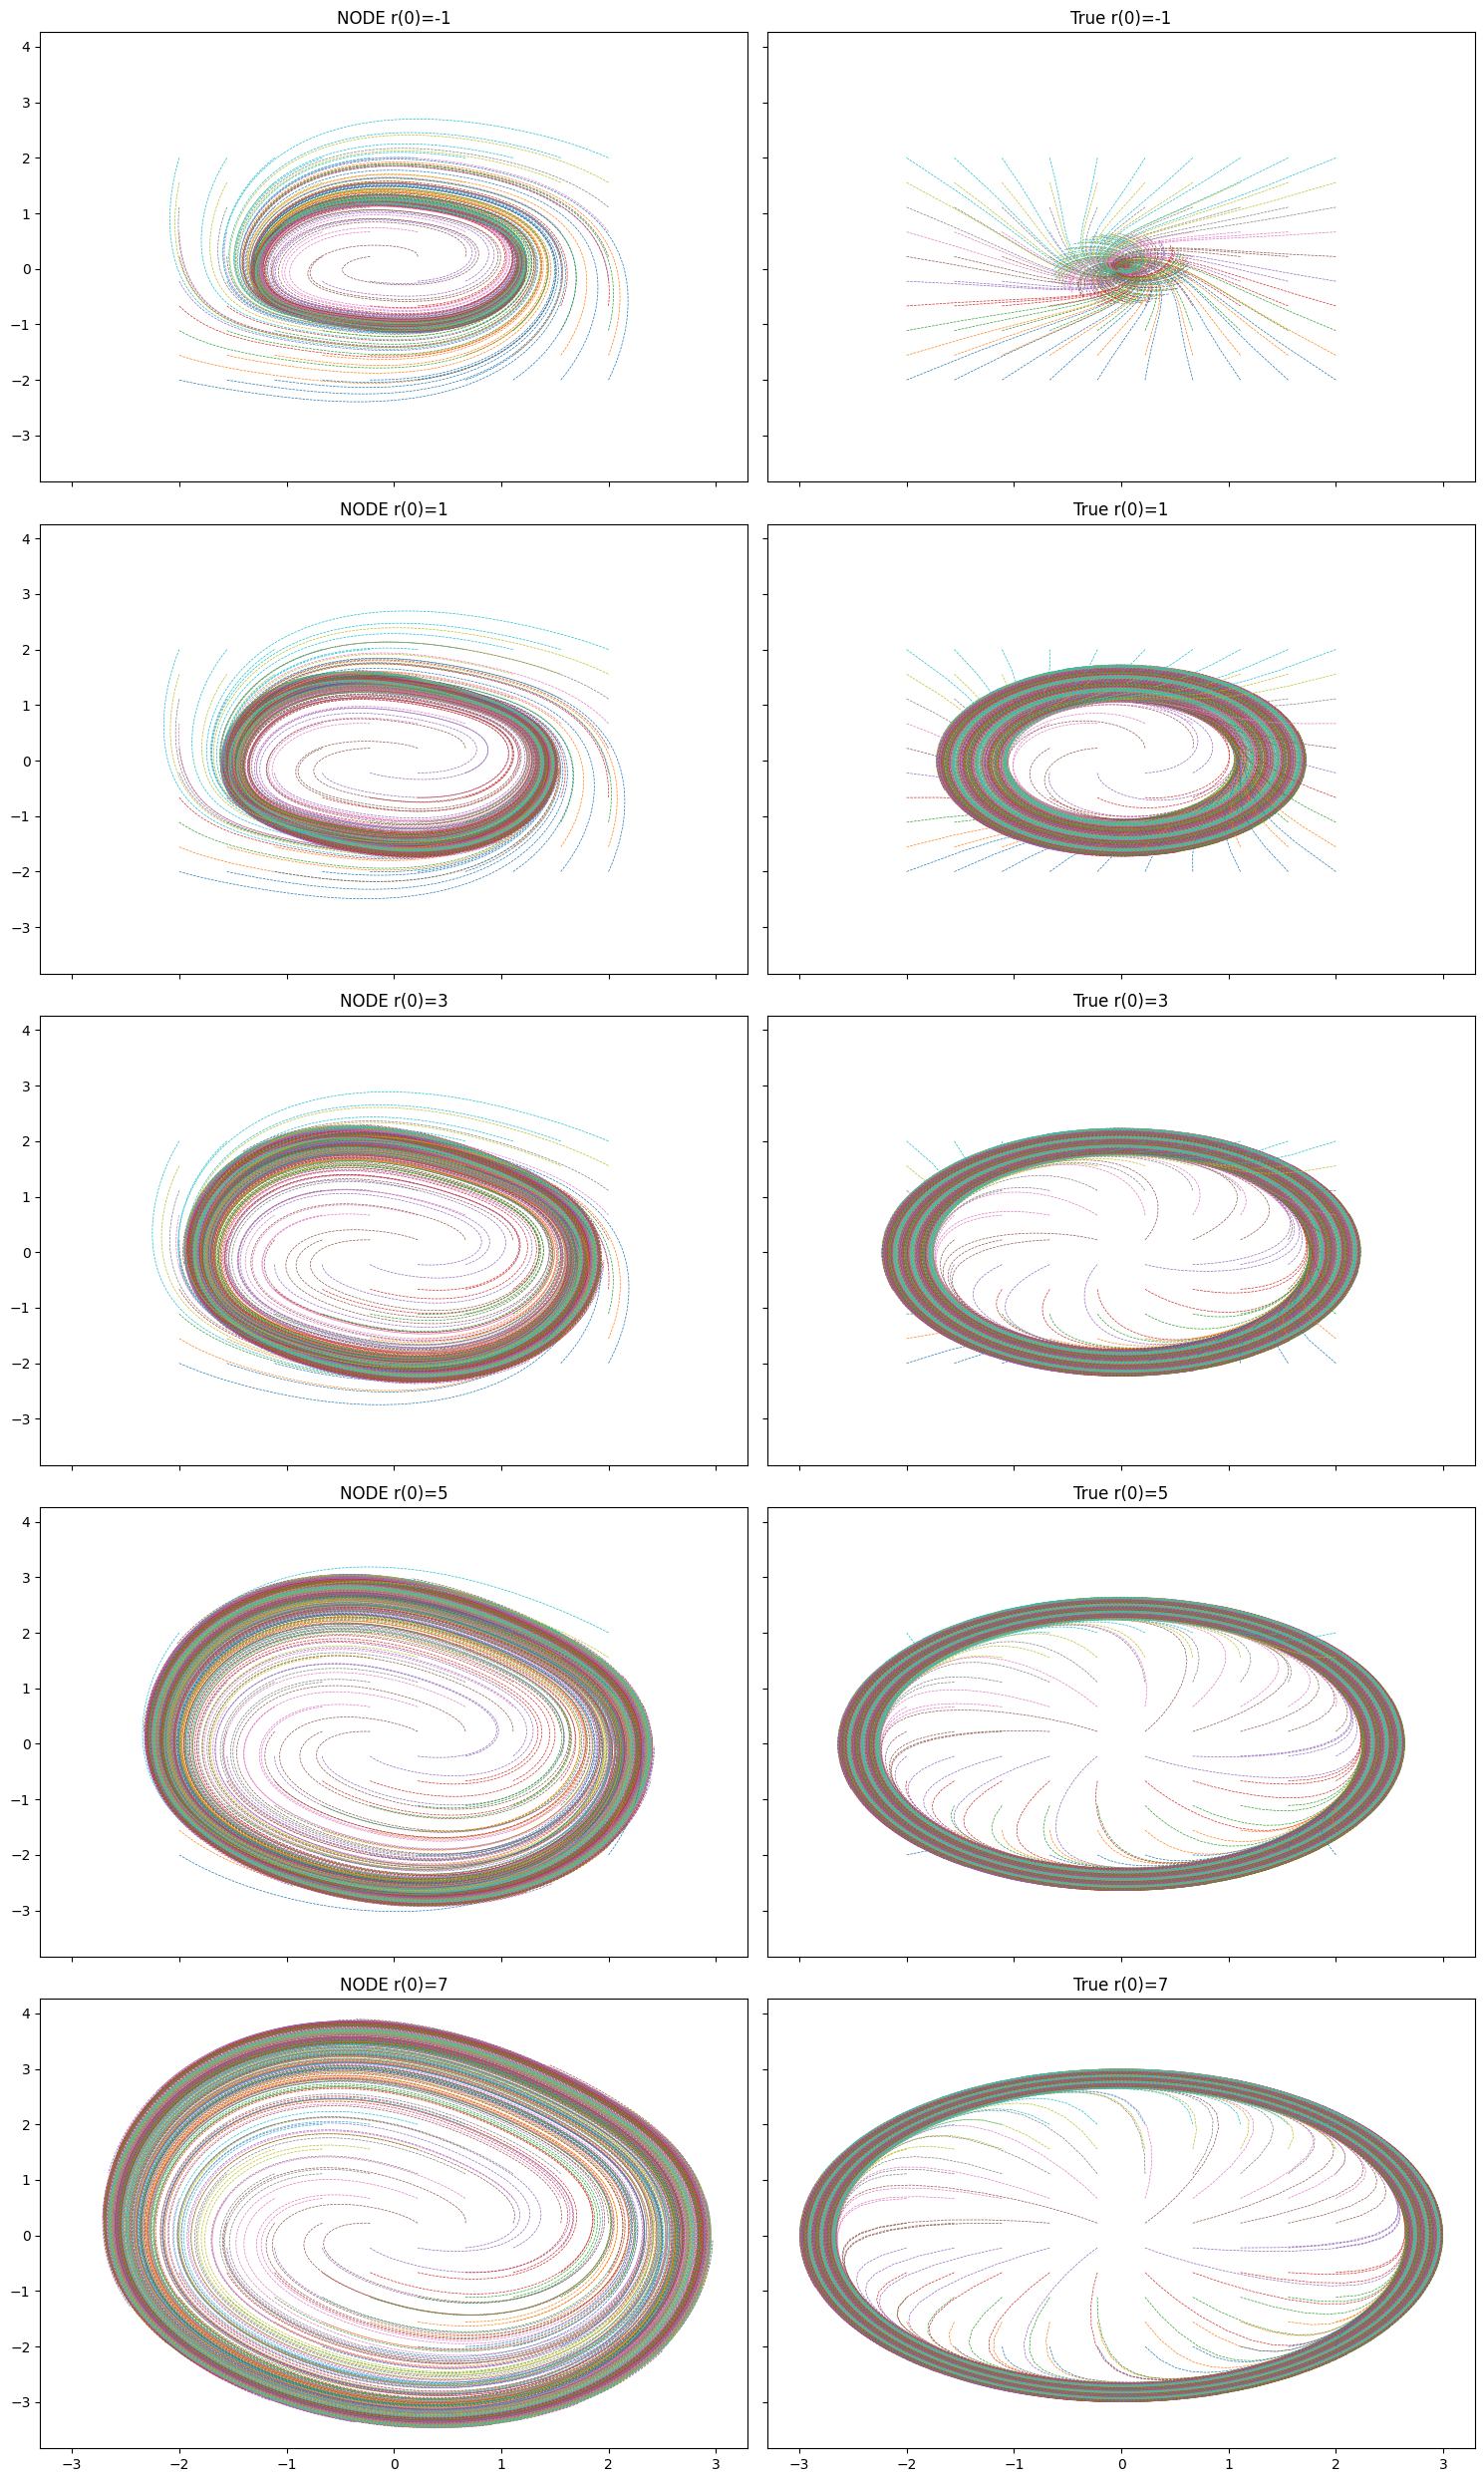

In [25]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

In [372]:
pts.shape

torch.Size([11000, 3])

In [22]:
# Interactive trajectory plot
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def plot_traj(idx=0):
    fig = plt.figure(figsize=(15, 8))
    r_val = r_vals[idx]
    print('rho = ', r_val.float())
    #First Plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(node_data[:, pts[:, 2] == r_val, 0].detach().numpy(), node_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(true_data[:, pts[:, 2] == r_val, 0].detach().numpy(), true_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')


In [23]:
interact(plot_traj, idx=IntSlider(min=0.0, max=r_vals.shape[0]-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=109), Output()), _dom_classes=('widget-interac…

<function __main__.plot_traj(idx=0)>

# Static $\rho $

In [31]:
def odewrapper(t, x):
    out = model(t, x)
    #out[:, 2] = torch.zeros_like(out[:, 2])
    out[:, 2] = 2*out[:, 2]
    return out

In [32]:
r_vals = torch.arange(-1.0, 10.0, 0.1)

a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b, r_vals)

t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
node_data = odeint(odewrapper, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

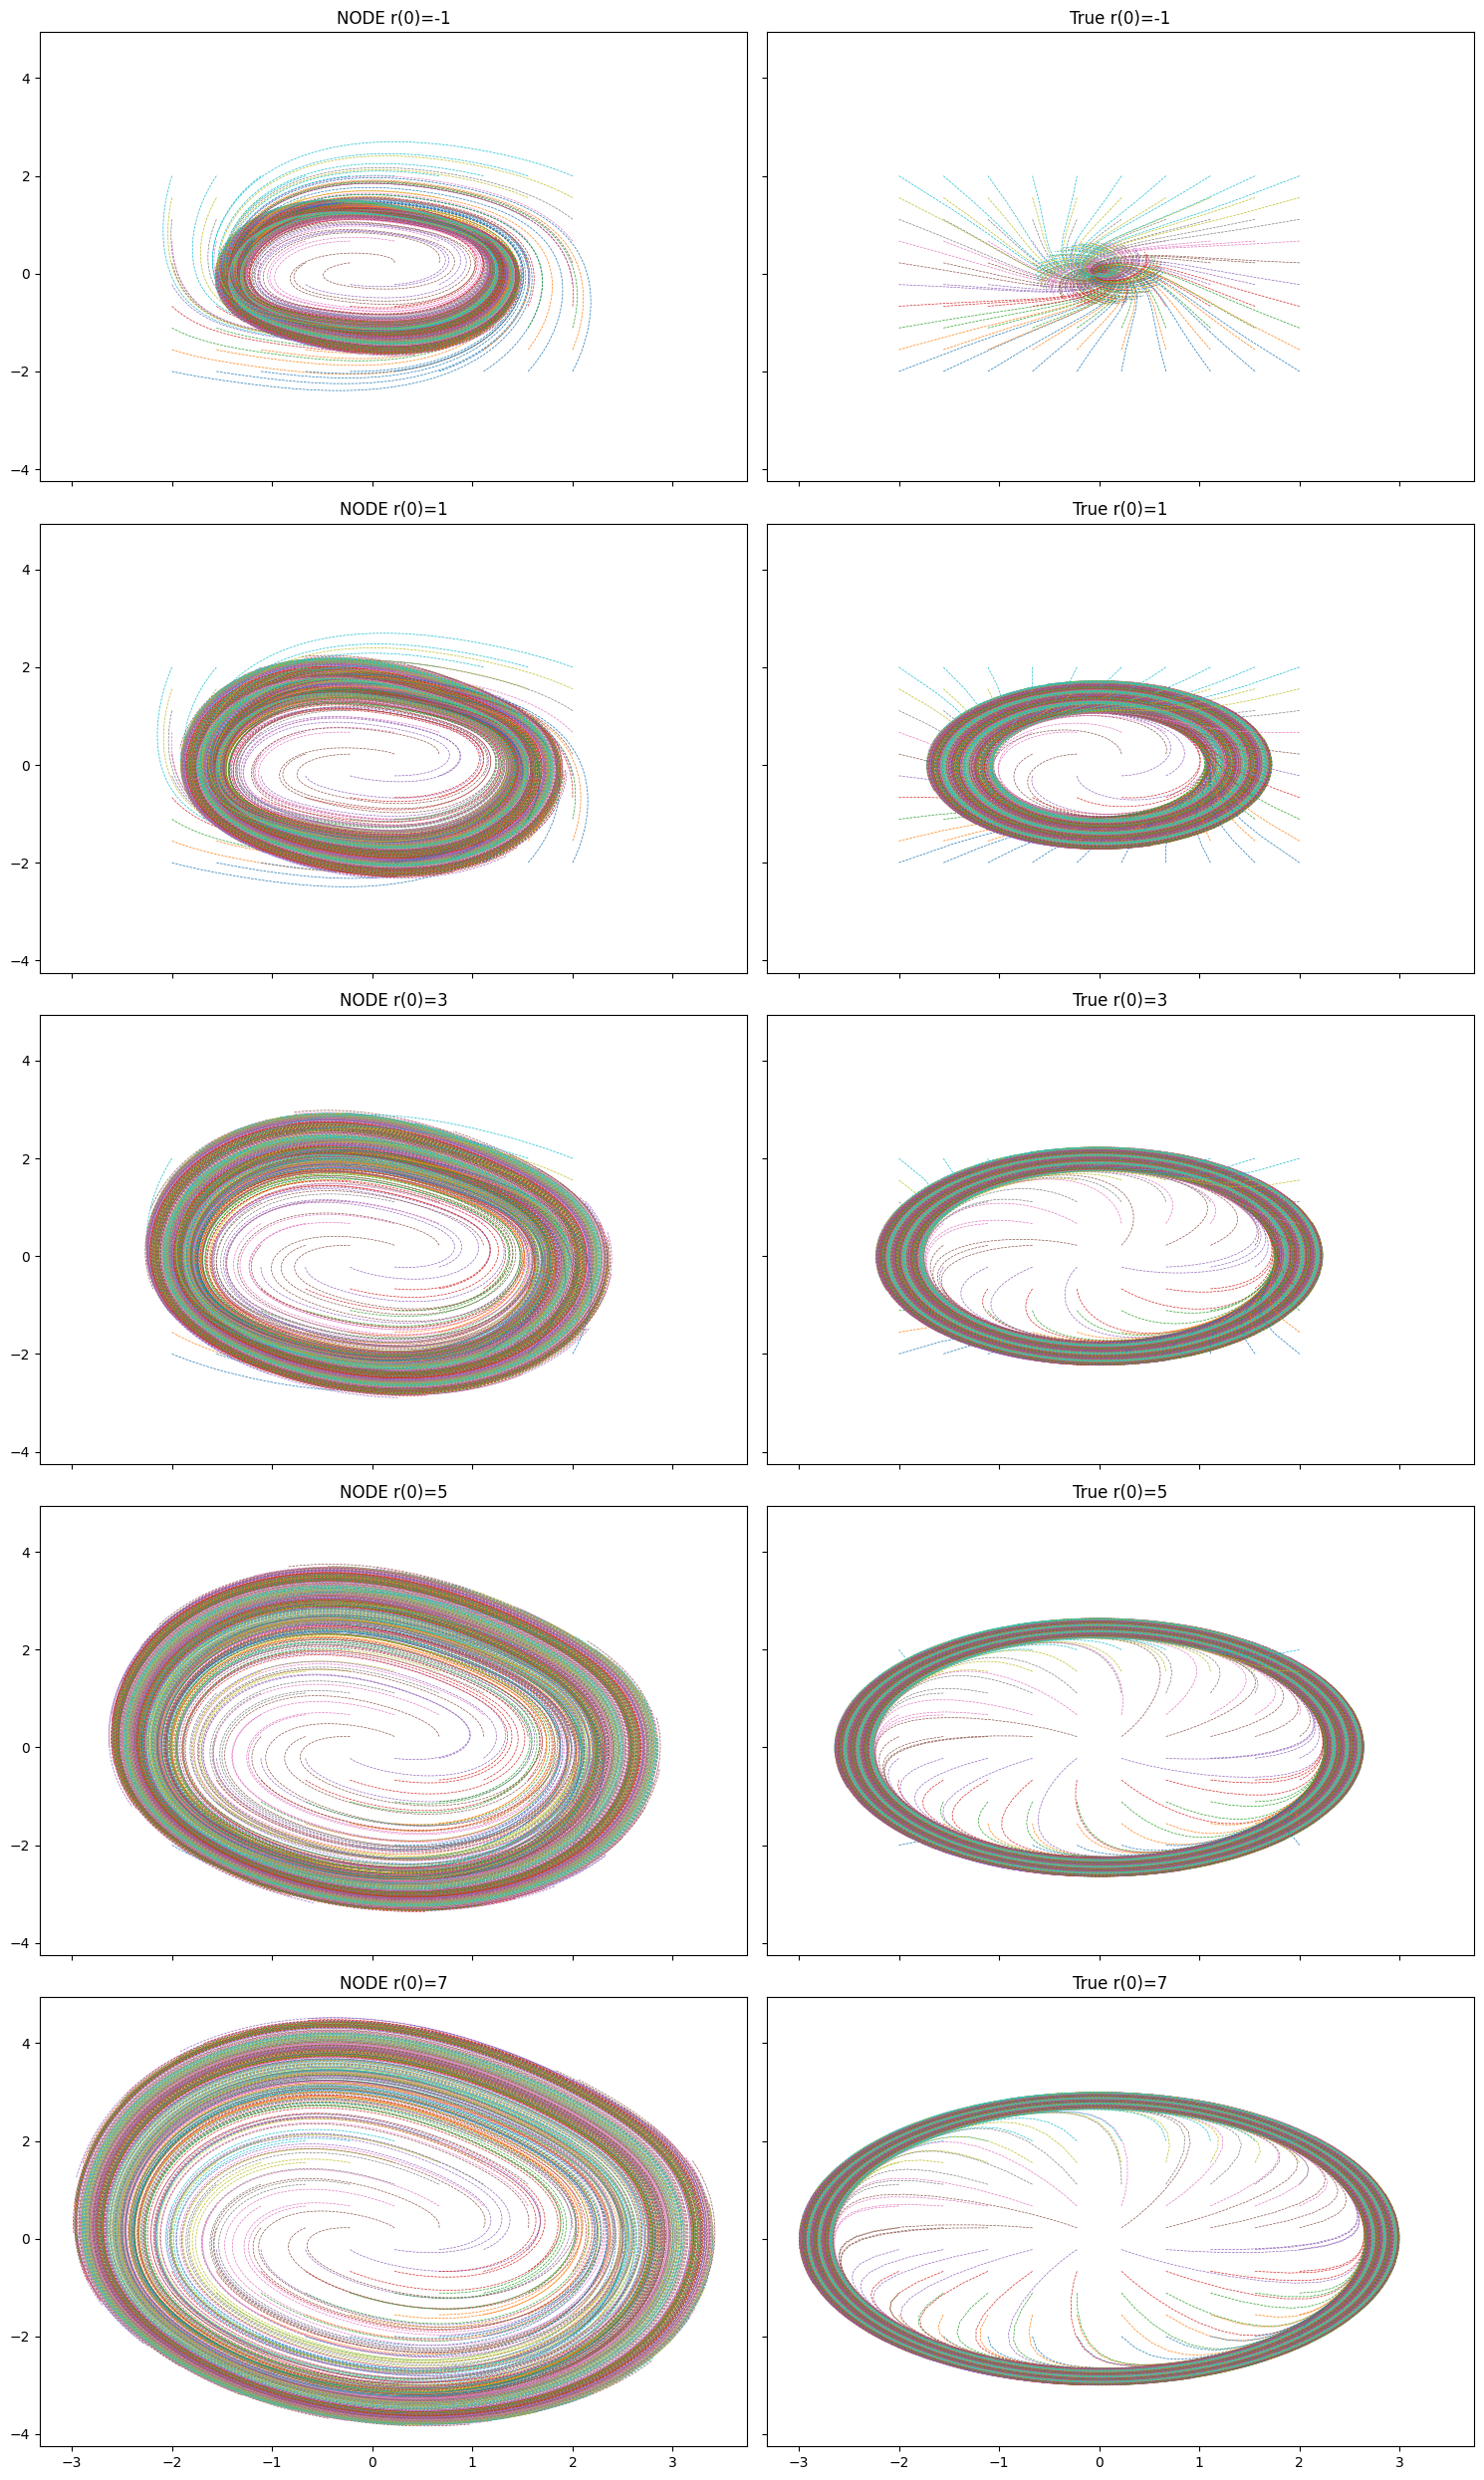

In [33]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

torch.Size([100, 3])

In [65]:
def odewrapper2(t, x):
    out = model(t, x)
    out[:, 2] = 2*out[:, 2]
    return out

def odewrapper3(t, x):
    out = model(t, x)
    return out

def odewrapper(t, x):
    out = model(t, x)
    out[:, 2] = torch.zeros_like(out[:, 2])
    #out[:, 2] = 2*out[:, 2]
    return out

In [81]:
node_data_static = odeint(odewrapper, pts[pts[:, 2] == -1, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})
node_data_dynamic = odeint(odewrapper3, pts[pts[:, 2] == 2, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})
node_data_fast = odeint(odewrapper2, pts[pts[:, 2] == 2, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})

Text(0.5, 1.0, '$2 \\dot \\rho$')

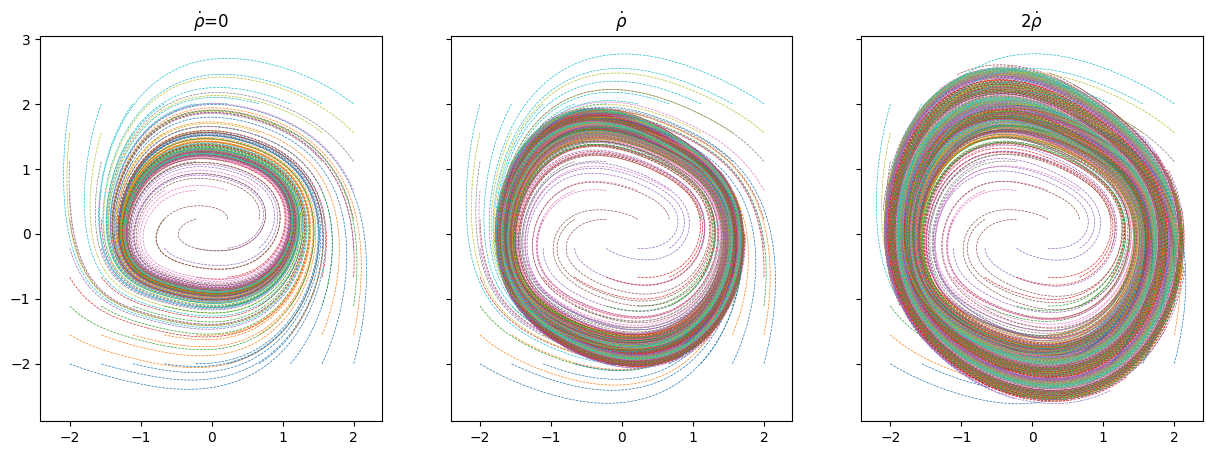

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].plot(node_data_static[:, :,  0].detach().numpy(),
                node_data_static[:, :,  1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[1].plot(node_data_dynamic[:, :, 0].detach().numpy(),
                node_data_dynamic[:, :, 1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[2].plot(node_data_fast[:, :, 0].detach().numpy(),
                node_data_fast[:, :, 1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[0].set_title(r'$\dot \rho$'+f"=0")
axes[1].set_title(r'$\dot \rho$')
axes[2].set_title(r'$2 \dot \rho$')

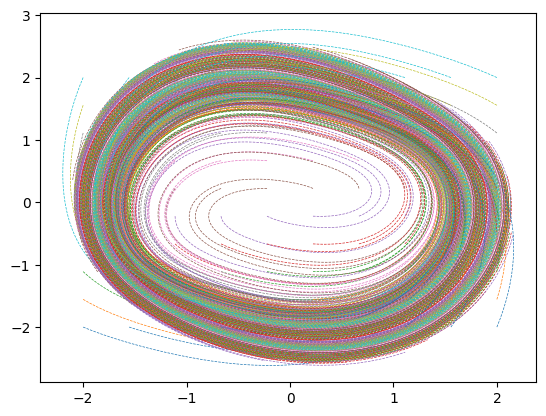

In [54]:
plt.plot(node_data_static[:, :, 0].detach().numpy(), node_data_static[:, :, 1].detach().numpy(),
          linewidth=0.5, alpha=1, linestyle='--')